In [2]:
# %% Preparo todo, cargo packages
import sys
sys.path.insert(1, '../')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import fcnAFIL
import lesion_classifiers as lc
import time
import SimpleITK as sitk
from scipy.optimize import curve_fit
from scipy.stats import norm

            

if os.environ['COMPUTERNAME']=='DIEGO-DESKTOP':
    datadir = 'E:/Entelai/DATA/Dataset 6x24'
    codedir = 'E:/REPOS/entelai_threshold_finetuning/'
else:
    datadir = 'C:/Entelai/DATA/Dataset_6x4_24'
    codedir = 'C:/REPOS/entelai_threshold_finetuning/'
    
outdatadir = os.path.join(datadir, 'out')

#### Function def

In [91]:
# %% Defino funciones de ploteo

def df_extract_vp_dvp(PAR,samereso):
    vol1 = np.array([])
    vol2 = np.array([])
    sid = np.array([])
    samereso = np.array([])
    for par in PAR:
        if 'LVTM' not in par:
            continue
        # if 'samereso' in par:
        #     if par['samereso'] not in samereso:
        #         continue  
        item = par['LVTM']
        vol1 = np.append(vol1,item[:,1])
        vol2 = np.append(vol2,item[:,2])
        ndata = len(item[:,2])
        sid = np.append(sid,np.repeat(par['studies'][0]['subject'],ndata))
        samereso = np.append(samereso,np.repeat(par['samereso'],ndata))

    df = pd.DataFrame([vol1,vol2,sid,samereso],index=['vol1','vol2','sid','samereso']).T
   
    df['vp'] = (df['vol2']+df['vol1'])/2.
    df['dvp'] = (df['vol2']-df['vol1'])/df['vp']*100.
    df = df.sort_values('vp')

    df = df[(df.vol1>0) & (df.vol2>0)]
    
    return df

def plotv1v2(v1,v2,maxx):
    plt.plot(v1,v2,'.')
    plt.axis('square')
    plt.xlim([0,maxx])
    plt.ylim([0,maxx])
    plt.grid(True)
    x = np.linspace (0,maxx,1000)
    plt.plot(x, x, 'k--',linewidth=0.5,label='_hidden')
    plt.xlabel('V$_1$ [mm$^3$]')
    plt.ylabel('V$_2$ [mm$^3$]')

def plotdvpdv(v1,v2):
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100
    plt.plot(dvp,vp,'.')
    plt.xlim([-200,200])
    plt.grid(True)
    plt.xlabel("% volume change")
    plt.ylabel("Mean volume [mm$^3$]")


def plot_v1v2_dvpdv(v1,v2,maxx=None):
    v1 = np.array(v1)
    v2 = np.array(v2)
    if maxx is None:
        maxx = max(max(v1),max(v2))*1.05
    
    plt.figure()
    h=dict()
    h['fig'] = plt.gcf()
    h['fig'].set_size_inches(7, 7)    
    
    h['h1'] = plt.subplot(221)
    # plotv1v2(v1,v2,maxx)
    plotv1v2(v1,v2,maxx)
    

    h['h2'] = plt.subplot(222)
    # plotv1v2(v1,v2,maxx*1.3)
    plotv1v2(v1,v2,maxx*1.3)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([.7,maxx])
    plt.ylim([.7,maxx])    

    h['h3'] = plt.subplot(223)
    # plotdvpdv(v1,v2)
    plotdvpdv(v1,v2)
    plt.ylim([.7,maxx])    

    h['h4'] = plt.subplot(224)
    plotdvpdv(v1,v2)
    # plotdvpdv(v1,v2)
    plt.yscale('log')
    plt.ylim([.7,maxx])    
    
    plt.tight_layout()
    
    return h
    
def plot_v1v2_4escalas(v1,v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    maxx = max(max(v1),max(v2))*1.05
    
    plt.figure()
    h=dict()
    h['fig'] = plt.gcf()
    h['fig'].set_size_inches(7, 7)    
    
    h['h1'] = plt.subplot(221)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 100])
    plt.ylim([0, 100])

    h['h2'] = plt.subplot(222)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 250])
    plt.ylim([0, 250])

    h['h3'] = plt.subplot(223)
    plotv1v2(v1,v2,maxx)
    plt.xlim([0, 1000])
    plt.ylim([0, 1000])
    
    h['h4'] = plt.subplot(224)
    plotv1v2(v1,v2,maxx)
    
    plt.tight_layout()
    return h

  

def Agrego2sdSmallLarge(h1s,h2s,umbral, sd1,sd2):    
    for ax in h1s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        
        x = np.linspace (0,umbral,1000)
        y = x*(1+nstd*sd1/100)
        plt.plot(x, y, 'g')
        plt.plot([umbral, umbral],[umbral,umbral*(1+nstd*sd1/100)],'--g')
        plt.plot([umbral, umbral],[0,maxx],'--g')
        x = np.linspace (umbral,maxx,1000)
        y = x*(1+nstd*sd2/100)
        plt.plot(x, y, 'g',label="sd(%Vc) small/large")
    
    for ax in h2s:
        plt.sca(h[ax])
        ylim = plt.ylim()
    
        plt.plot([-nstd*sd1,nstd*sd1],[umbral, umbral],'--g')
        plt.plot([nstd*sd1,nstd*sd1],[.1, umbral],'g')
        plt.plot([-nstd*sd1,-nstd*sd1],[.1, umbral],'g')
        plt.plot([nstd*sd2,nstd*sd2],[1e4, umbral],'g')
        plt.plot([-nstd*sd2,-nstd*sd2],[1e4, umbral],'g')
        plt.ylim(ylim)  
        
def Agrego2sdExpFit(h1s,h2s,popt):    
    for ax in h1s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        x = np.linspace (0,maxx,1000)
        plt.plot(x, x*(1+nstd*func(x,*popt)/100), 'c',linewidth=2,label="Exp fit of in sd(%Vc)")
        # plt.plot(x, x+nstd*func(x,*popt), 'c',linewidth=2,label="Exp fit of in sd(%Vc)")
    
    for ax in h2s:
        plt.sca(h[ax])
        maxx = max(plt.ylim())
        
        x=range(0,int(maxx))
        plt.plot(nstd*func(x,*popt),x, 'c',linewidth=2)

def AgregoRecta(h1s,h2s,oo,pend):    
    x = np.linspace (0,65,66)
    v1 = x
    v2 = oo + pend*v1
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100    
    for ax in h1s:
        plt.sca(h[ax])        
        plt.plot(v1,v2,'r')        
    
    for ax in h2s:
        plt.sca(h[ax])             
        plt.plot(dvp,vp, 'r',linewidth=2)


def AgregoRectaTramo(h1s,h2s,x,oo,pend,color='r',label=None):    
    v1 = x
    v2 = oo + pend*v1
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100    
    for ax in h1s:
        plt.sca(h[ax])        
        plt.plot(v1,v2,color=color,label=label)        
    
    for ax in h2s:
        plt.sca(h[ax])             
        plt.plot(dvp,vp, color=color,linewidth=2)

def AgregoCte(h1s,h2s,cte=48,color='r',label=None):
    v1 = np.logspace(-1,5,100)
    v2 = v1 + cte
    for ax in h1s:
        plt.sca(h[ax])
        # maxx = max(plt.ylim())
        plt.plot(v1,v2, color=color,label=label)

    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100          
    for ax in h2s:
        plt.sca(h[ax])
        ylim = plt.ylim()
        # x = np.logspace(-1,5,100)
        # plt.plot(100*1/((x/48)),x,'r',linewidth=2)
        plt.plot(dvp,vp,color=color,linewidth=2)
        plt.ylim(ylim)  


def AgregoPotencia(h1s,h2s,x,factor=1,potencia=2/3,color='r',label=None):    
    v1 = x
    v2 = x + factor*x**(potencia)
    vp = (v2+v1)/2.
    dvp = (v2-v1)/vp*100    
    for ax in h1s:
        plt.sca(h[ax])        
        plt.plot(v1,v2,color=color,label=label)        
    
    for ax in h2s:
        plt.sca(h[ax])             
        plt.plot(dvp,vp, color=color,linewidth=2,label=label)

In [107]:
# %% exponencial stdev of %Vc vs mean volume

loaded = np.load(os.path.join(datadir,'PARES_6x4.npz'), allow_pickle=True)
loaded.files
PAR = list(loaded['PAR'])

nstd = 2.32634
nstd = 3
nstd = 6

samereso = [True]
samereso = [False]
# samereso = [True, False]

df = df_extract_vp_dvp(PAR,samereso)
vp, dvp, vol1, vol2 = df['vp'],df['dvp'],df['vol1'],df['vol2']
samereso = df['samereso']
df

,vol1,vol2,sid,samereso,vp,dvp
1449,1.0,1.0,GAM,1.0,1.0,0.0
2696,1.0,1.0,VVS,0.0,1.0,0.0
66,1.0,1.0,CIM,1.0,1.0,0.0
2830,1.0,1.0,VVS,1.0,1.0,0.0
2832,1.0,1.0,VVS,1.0,1.0,0.0
...,...,...,...,...,...,...
764,2536.0,2178.0,FRO,0.0,2357.0,-15.188799
891,2536.0,2215.0,FRO,0.0,2375.5,-13.512945
1235,2178.0,2591.0,FRO,0.0,2384.5,17.320193
1347,2215.0,2591.0,FRO,0.0,2403.0,15.647108


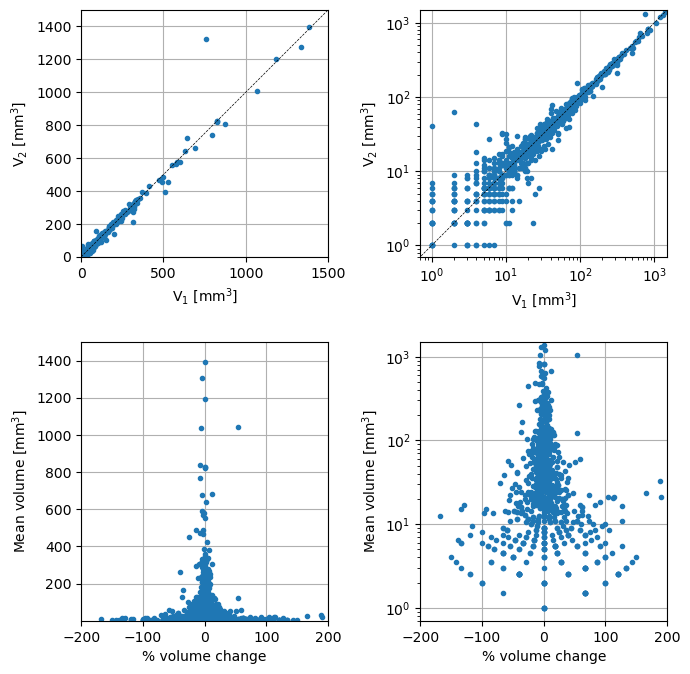

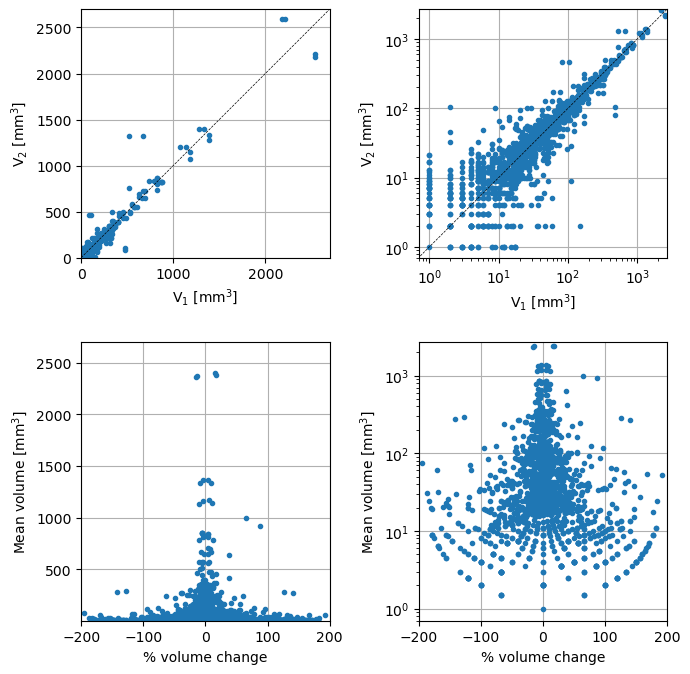

In [441]:
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=1500)

df_plot = df.query('samereso==0').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=2700)


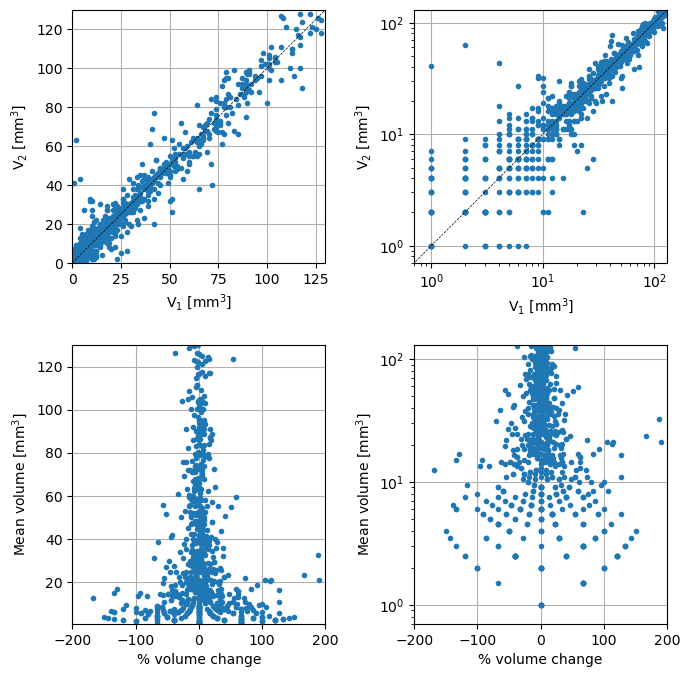

In [109]:
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=130)


[6.83876914e+01 4.42337137e-02 9.72678858e+00]
el desvío de los residuos es 5.25945
Amplitud: 68.39
Tau: 22.61
3*Tau: 67.82
Offset: 9.73
valor de la exponencial en 3tau es 3.85743


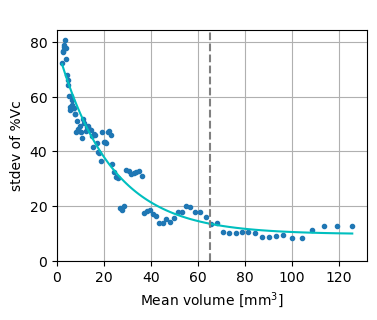

In [145]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(figsize=(4,3))

def std_vs_mean(vp,dvp):
    ventana = 50
    nventanas = 100
    x=np.zeros(nventanas)
    x[:] = np.nan
    y=np.zeros(nventanas)
    x[:] = np.nan
    for i in range(nventanas):
        desde = int(i*np.floor((len(vp)-ventana)/nventanas))
        hasta = desde + ventana        
        x[i] = np.mean(vp[desde:hasta])
        y[i] = np.std(dvp[desde:hasta])
    return x,y

df_plot = df.query('samereso==1').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    
popt, pcov = curve_fit(func, x, y,p0=[80,0.04,10])
print(popt)
# plt.plot(x,y-func(x, *popt),'.',label='Residuos')
plt.plot(x,func(x, *popt),'c',label='Fit')

print("el desvío de los residuos es %g" % np.std(y-func(x, *popt)))
(func(65, *popt))-float(popt[2])
print(f'Amplitud: {popt[0]:.2f}')
print(f'Tau: {1/popt[1]:.2f}')
print(f'3*Tau: {3/popt[1]:.2f}')

print(f'Offset: {popt[2]:.2f}')
print("valor de la exponencial en 3tau es %g" % (float(func(65, *popt))-float(popt[2])))
plt.grid(True)
plt.ylim([0,max(plt.ylim())])
maxx= max(x) * 1.05
plt.xlim([0 ,maxx])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.title('  ')
plt.axvline(x=65,ymin=0,ymax=100,c=[.5,.5,.5],ls='--')
    

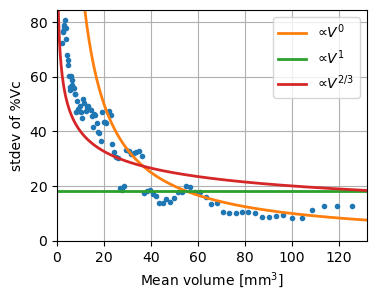

In [192]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(figsize=(4,3))

df_plot = df.query('samereso==1').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

maxx = max(x)*1.05 
plt.plot(x,y,'.')  

plt.grid(True)
plt.ylim([0,max(plt.ylim())])
maxx= max(x) * 1.05
plt.xlim([0 ,maxx])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')


x = np.linspace(0.0001,130,1000)

factor=10
potencia=0
v1 = x
v2 = x + factor*x**(potencia)
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100   
plt.plot(vp,dvp, color=plt.get_cmap('tab10')(1),label='$∝V^0$',linewidth=2)


factor=.2
potencia=1
v1 = x
v2 = x + factor*x**(potencia)
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100   
plt.plot(vp,dvp, color=plt.get_cmap('tab10')(2),label='$∝V^1$',linewidth=2)

factor=1
potencia=2/3
v1 = x
v2 = x + factor*x**(potencia)
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100    
plt.plot(vp,dvp, color=plt.get_cmap('tab10')(3),label='$∝V^{2/3}$',linewidth=2)
plt.legend()

In [160]:
np.mean(y)

36.64603920027114

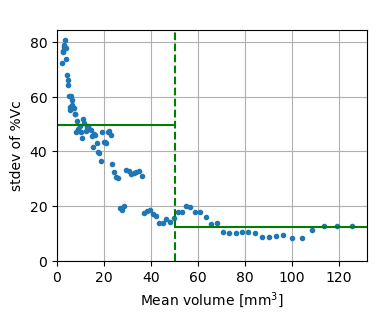

In [137]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(figsize=(4,3))

df_plot = df.query('samereso==1').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

maxx = max(x)*1.05 
plt.plot(x,y,'.',label='data')    

plt.grid(True)
plt.ylim([0,max(plt.ylim())])
maxx= max(x) * 1.05
plt.xlim([0 ,maxx])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')
plt.title('  ')

umbral = 50
sd1 = df_plot.query('vp<@umbral')['dvp'].std()
sd2 = df_plot.query('vp>@umbral')['dvp'].std()
plt.plot([0,umbral],[sd1,sd1],'g')
plt.plot([umbral,200],[sd2,sd2],'g')
plt.plot([umbral,umbral],[0,100],'g--')

Text(0.5, 1.0, '  ')

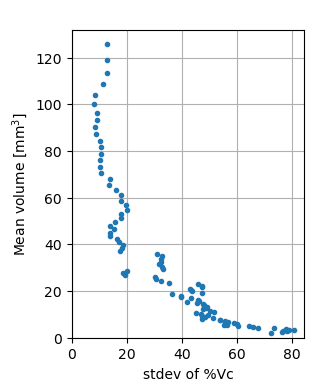

In [112]:
plt.figure(figsize=(3,4))
maxx = max(x)*1.05 
plt.plot(y,x,'.',label='data')    

plt.grid(True)
plt.xlim([0,max(plt.xlim())])
maxx= max(x) * 1.05
plt.ylim([0 ,maxx])
plt.ylabel('Mean volume [mm$^3$]')
plt.xlabel('stdev of %Vc')
plt.title('  ')

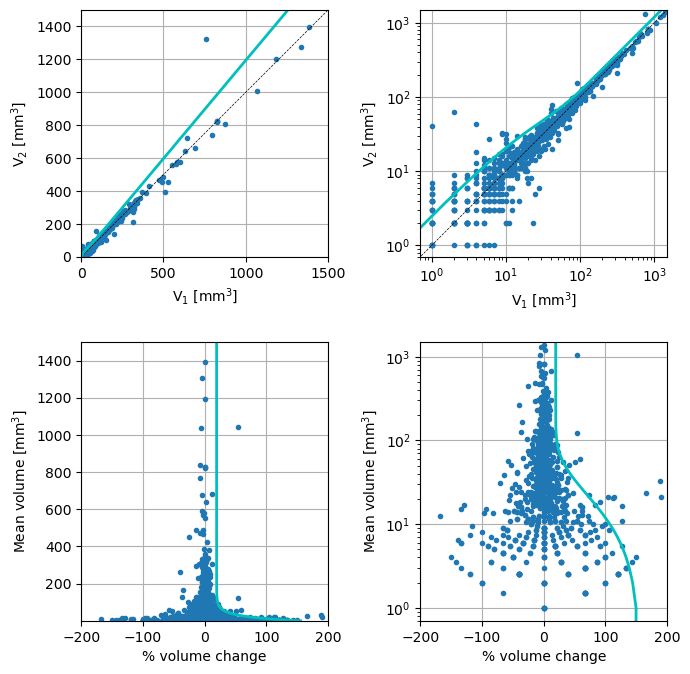

In [121]:
umbral = 65
sd1 = 61
sd2 = 23
df_plot = df.query('samereso==1 and vp<1500').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=1500)
# AgregoCte(['h1','h2'],['h3','h4'])
# nstd = 1
# Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, sd1,sd2)
# Agrego2sdExpFit(['h1','h2'],['h3','h4'],np.array([68,0.044,9.7])) 
nstd = 2
# Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, sd1,sd2)
Agrego2sdExpFit(['h1','h2'],['h3','h4'],np.array([68,0.044,9.7])) 



#### Constante, lineal, 2/3

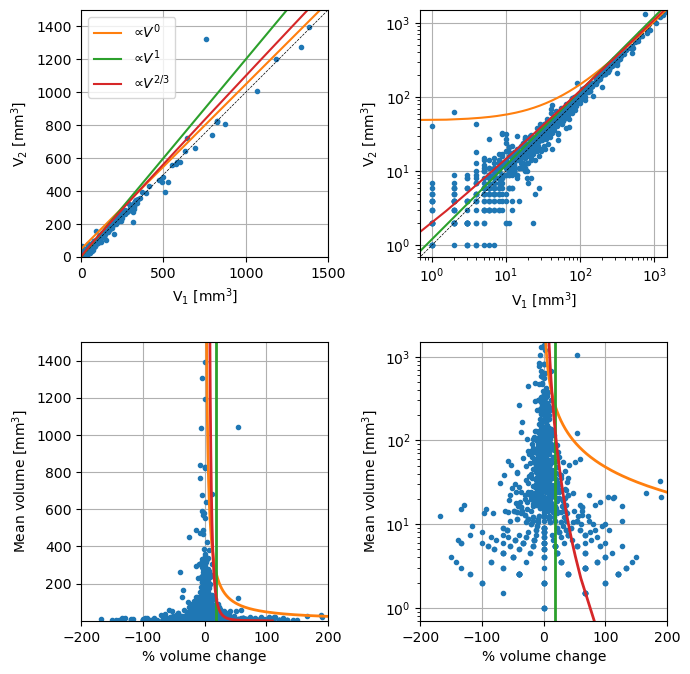

In [114]:
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=1500)

x = np.linspace(0.07,1500,1000)
oo=48
pend=1.
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,oo,pend,color=plt.get_cmap('tab10')(1),label='$∝V^0$')

oo=0
pend=1.2
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,oo,pend,color=plt.get_cmap('tab10')(2),label='$∝V^1$')

factor=1
potencia=2/3
AgregoPotencia(['h1','h2'],['h3','h4'],x,factor,potencia,color=plt.get_cmap('tab10')(3),label='$∝V^{2/3}$')
h['h1'].legend()

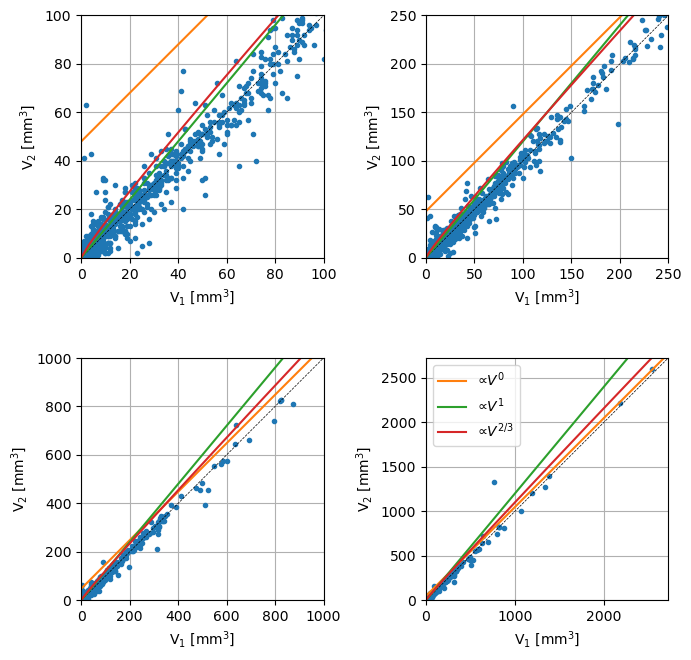

In [154]:
h = plot_v1v2_4escalas(df_plot['vol1'],df_plot['vol2'])

x = np.linspace(0.07,3000,1000)
oo=48
pend=1.
AgregoRectaTramo(['h1','h2','h3','h4'],[],x,oo,pend,color=plt.get_cmap('tab10')(1),label='$∝V^0$')

oo=0
pend=1.2
AgregoRectaTramo(['h1','h2','h3','h4'],[],x,oo,pend,color=plt.get_cmap('tab10')(2),label='$∝V^1$')

factor=1
potencia=2/3
AgregoPotencia(['h1','h2','h3','h4'],[],x,factor,potencia,color=plt.get_cmap('tab10')(3),label='$∝V^{2/3}$')
h['h4'].legend()

### Criterio final

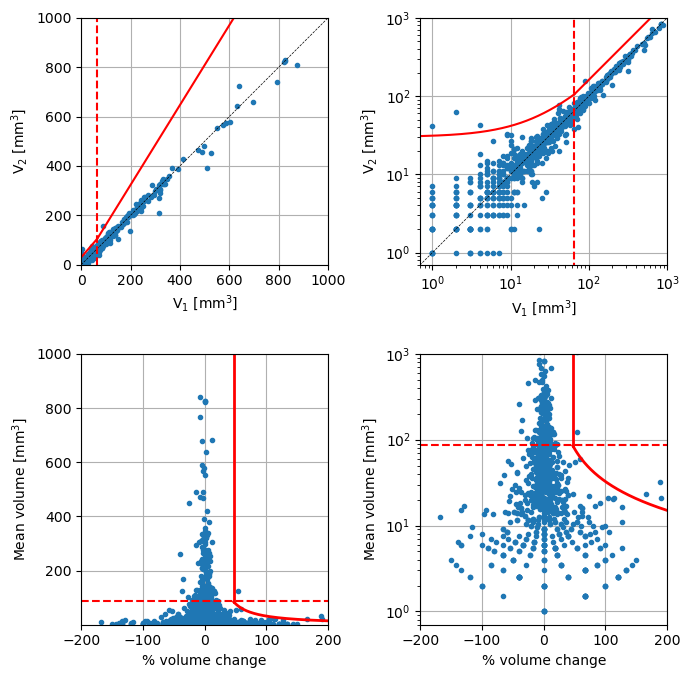

In [443]:


umbral = 65
df_plot = df.query('samereso==1').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=1000)


x = np.linspace(umbral,1500,1000)
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,0,1.61692)
x = np.linspace(0,umbral,1000)
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,30,1.1554)

h['h1'].plot([umbral,umbral],[0,1500],'r--')
h['h2'].plot([umbral,umbral],[0,1500],'r--')
umbral = 100/1.1554 # esto sale de hcaer la cuenta, de proponer el umbral en V1 y 
h['h3'].plot([-200,200],[umbral,umbral],'r--')
h['h4'].plot([-200,200],[umbral,umbral],'r--')

# x = np.linspace(umbral,1500,1000)
# AgregoRecta2(['h1','h2'],['h3','h4'],x,0,1.4112)
# x = np.linspace(0,umbral,1000)
# AgregoRecta2(['h1','h2'],['h3','h4'],x,25.365,1.02104)



# : V_2C = 25.365 + V1 * 1.02104
# Ecuación de la recta 2: V_2C = V1 * 1.4112


# nstd = 2
# Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, sd1,sd2)
# Agrego2sdExpFit(['h1','h2'],['h3','h4'],np.array([68,0.044,9.7])) 

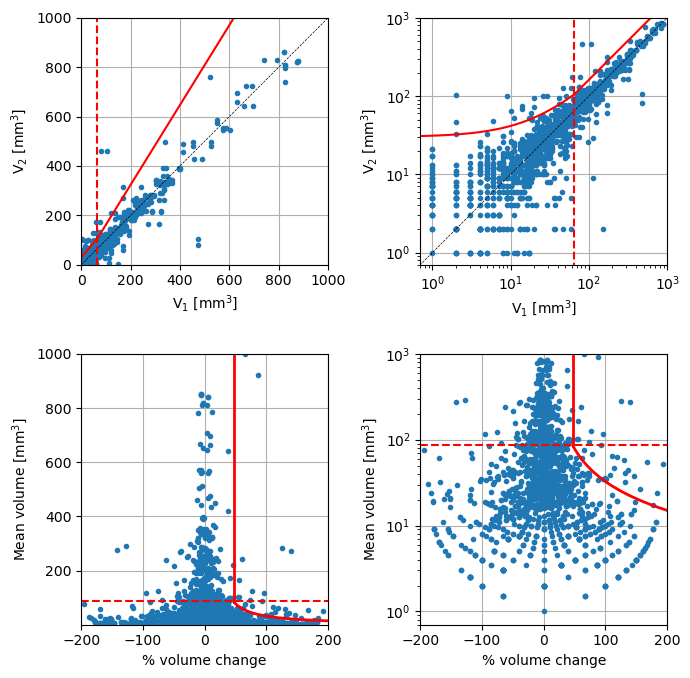

In [437]:

umbral = 65
df_plot = df.query('samereso==0').copy()
h = plot_v1v2_dvpdv(df_plot['vol1'],df_plot['vol2'],maxx=1000)


x = np.linspace(umbral,1500,1000)
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,0,1.61692)
x = np.linspace(0,umbral,1000)
AgregoRectaTramo(['h1','h2'],['h3','h4'],x,30,1.1554)

h['h1'].plot([umbral,umbral],[0,1500],'r--')
h['h2'].plot([umbral,umbral],[0,1500],'r--')
umbral = 100/1.1554 # esto sale de hcaer la cuenta, de proponer el umbral en V1 y 
h['h3'].plot([-200,200],[umbral,umbral],'r--')
h['h4'].plot([-200,200],[umbral,umbral],'r--')
# x = np.linspace(umbral,1500,1000)
# AgregoRecta2(['h1','h2'],['h3','h4'],x,0,1.4112)
# x = np.linspace(0,umbral,1000)
# AgregoRecta2(['h1','h2'],['h3','h4'],x,25.365,1.02104)



# : V_2C = 25.365 + V1 * 1.02104
# Ecuación de la recta 2: V_2C = V1 * 1.4112


# nstd = 2
# Agrego2sdSmallLarge(['h1','h2'],['h3','h4'],umbral, sd1,sd2)
# Agrego2sdExpFit(['h1','h2'],['h3','h4'],np.array([68,0.044,9.7]))

(0.0, 230.7795)
(0.0, 108.59929677763292)


(0.0, 84.4895104855803)

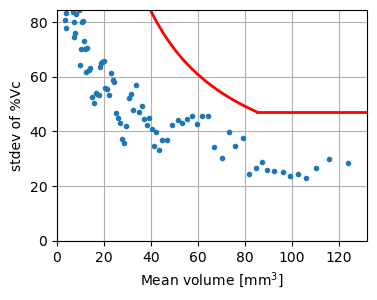

In [226]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(figsize=(4,3))


df_plot = df.query('samereso==0').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)
maxx = max(x)*1.05 

plt.plot(x,y,'.')  

plt.grid(True)
plt.ylim([0,max(plt.ylim())])
plt.xlim([0 ,maxx])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')


umbral = 65
x = np.linspace(umbral,1500,1000)
oo = 0
pend = 1.61692 
v1 = x
v2 = oo + pend*v1
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100    
plt.plot(vp,dvp, color='r',linewidth=2)

x = np.linspace(0,umbral,1000)
oo = 30
pend = 1.1554 
v1 = x
v2 = oo + pend*v1
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100    
plt.plot(vp,dvp, color='r',label='6SD',linewidth=2)


# umbral = 65
# x = np.linspace(umbral,1500,1000)
# oo = 0
# pend = 1.4112 
# v1 = x
# v2 = oo + pend*v1
# vp = (v2+v1)/2.
# dvp = (v2-v1)/vp*100    
# plt.plot(vp,dvp, color='r',linewidth=2)

# x = np.linspace(0,umbral,1000)
# oo = 25
# pend = 1.02104 
# v1 = x
# v2 = oo + pend*v1
# vp = (v2+v1)/2.
# dvp = (v2-v1)/vp*100    
# plt.plot(vp,dvp, color='r',label='4SD',linewidth=2)

# plt.legend()

print(plt.xlim())
print(plt.ylim())

plt.xlim((0.0, 131.943))
plt.ylim((0.0, 84.4895104855803))

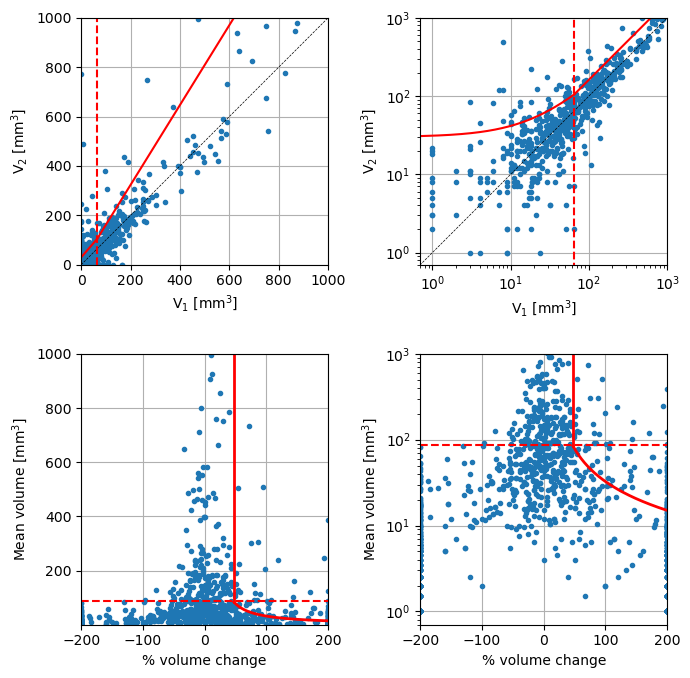

In [436]:
fname = os.path.join(datadir, "dataset_threshold_finetuning_all_lesions.xlsx")
df_plot = pd.read_excel(fname)
df_plot
h = plot_v1v2_dvpdv(df_plot['v1'],df_plot['v2'],maxx=1000)


x = np.linspace(umbral,2500,1000)
AgregoRecta2(['h1','h2'],['h3','h4'],x,0,1.61692)
x = np.linspace(0,umbral,1000)
AgregoRecta2(['h1','h2'],['h3','h4'],x,30,1.1554)

h['h1'].plot([umbral,umbral],[0,2500],'r--')
h['h2'].plot([umbral,umbral],[0,2500],'r--')
umbral = 100/1.1554 # esto sale de hcaer la cuenta, de proponer el umbral en V1 y 
h['h3'].plot([-200,200],[umbral,umbral],'r--')
h['h4'].plot([-200,200],[umbral,umbral],'r--')

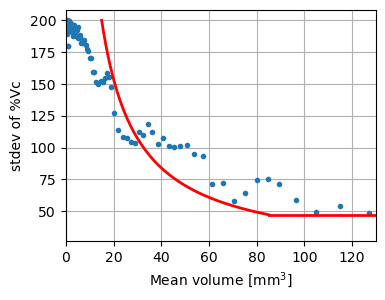

In [433]:
##########  Ajuste exponencial STD de %VC to mean volume
plt.figure(figsize=(4,3))

# df_plot = df.query('samereso==1').copy()
# x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

# maxx = max(x)*1.05 
# plt.plot(x,y,'.')  

# plt.grid(True)
# # plt.ylim([0,max(plt.ylim())])
# maxx= max(x) * 1.05
# plt.xlim([0 ,maxx])
# plt.xlabel('Mean volume [mm$^3$]')
# plt.ylabel('stdev of %Vc')


fname = os.path.join(datadir, "dataset_threshold_finetuning_all_lesions.xlsx")
df_plot = pd.read_excel(fname)

df_plot['vp'] = (df_plot['v2']+df_plot['v1'])/2.
df_plot['dvp'] = (df_plot['v2']-df_plot['v1'])/df_plot['vp']*100.
df_plot = df_plot.sort_values('vp')
# df = df[(df.vol1>0) & (df.vol2>0)]

# df_plot = df.query('samereso==1').copy()
x,y = std_vs_mean(df_plot.vp,df_plot.dvp)

maxx = max(x)*1.05 
plt.plot(x,y,'.')  

plt.grid(True)
# plt.ylim([0,max(plt.ylim())])
maxx= max(x) * 1.05
plt.xlim([0 ,130])
plt.xlabel('Mean volume [mm$^3$]')
plt.ylabel('stdev of %Vc')


umbral = 65
x = np.linspace(umbral,1500,1000)
oo = 0
pend = 1.61692 
v1 = x
v2 = oo + pend*v1
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100    
plt.plot(vp,dvp, color='r',linewidth=2)

x = np.linspace(0,umbral,1000)
oo = 30
pend = 1.1554 
v1 = x
v2 = oo + pend*v1
vp = (v2+v1)/2.
dvp = (v2-v1)/vp*100    
plt.plot(vp,dvp, color='r',label='6SD',linewidth=2)

86.55011251514627

In [1]:
df.sample(50)[['vol1','vol2']].astype(int)
df.query('sid=="VVS"').sample(50)[['vol1','vol2']].astype(int)

NameError: name 'df' is not defined

In [101]:
fname = os.path.join(datadir, "dataset_threshold_finetuning_all_lesions.xlsx")
df_plot = pd.read_excel(fname)
df_plot

,subject,id,v1,v2,cat 4tau,cat 6tau samereso,cat 6tau diffreso,all stable
0,37745,1,32,4,stable,stable,stable,True
1,37745,2,90,77,stable,stable,stable,True
2,37745,3,24,0,stable,stable,stable,True
3,37745,4,3,0,stable,stable,stable,True
4,37745,5,150,202,stable,stable,stable,True
...,...,...,...,...,...,...,...,...
1446,633636,68,0,18,grow,stable,stable,False
1447,633636,69,0,4,stable,stable,stable,True
1448,633636,70,0,19,grow,stable,stable,False
1449,633636,71,0,33,grow,new,new,False


In [104]:
df_plot.subject.unique()

array([ 37745,  97997, 153777, 156196, 265833, 290231, 335001, 377100,
       422917, 462859, 466816, 582025, 599032, 626291, 633636],
      dtype=int64)

# Análisis de la survey del paper

In [402]:
fname = os.path.join("MS_Atrophy_Survey_Responses_corregido.csv")

df_survey = pd.read_csv(fname)
df_survey
# Evaluacion: ¿Solicitarías a este paciente una evaluación neurocognitiva?' (Si|No)
# Pronostico: ¿Cuál crees que es el pronóstico respecto a la evolución de la enfermedad de este paciente?' (1,2,3,4,5)
# Tratamiento: ¿Qué decisión tomarías respecto al tratamiento modificador de enfermedad (TME)? 0: nada, 1 primera línea, 2: segunda línea


# str0 = "En mi opinión, este paciente no necesita un TME."
# str1 = "En mi opinión, este paciente debería recibir un TME de primera línea (Interferón beta, Acetato de glatirámer, Teriflunomida u otro)"
# str2 = "En mi opinión, este paciente debería recibir un TME de segunda línea (Fingolimod, Natalizumab, Ocrelizumab u otro)"

df_all = pd.DataFrame()
for i in range(1,5):
    print(i)
    df_temp = df_survey[['ID','Sesion','Marca temporal',f'tme{i}',f'evaluacion{i}',f'pronostico{i}']].rename(columns={f'tme{i}':'tme',f'evaluacion{i}':'evaluacion',f'pronostico{i}':'pronostico'}).copy()
    df_temp['caso'] = i
    df_all = pd.concat((df_all, df_temp))
df_all.reset_index(drop=True)

1
2
3
4


,ID,Sesion,Marca temporal,tme,evaluacion,pronostico,caso
0,1,1,4/10/2023 10:10,2,1,3,1
1,2,1,2/10/2023 20:44,1,1,3,1
2,3,1,3/10/2023 08:36,1,1,3,1
3,4,1,2/10/2023 21:24,2,1,2,1
4,5,1,3/10/2023 08:30,1,1,3,1
...,...,...,...,...,...,...,...
163,17,2,20/1/2024 08:10,2,1,1,4
164,18,2,16/11/2023 08:21,2,0,2,4
165,19,2,15/11/2023 22:42,2,1,3,4
166,20,2,15/11/2023 20:00,2,1,3,4


In [405]:
import seaborn as sns
# sns.stripplot(data = df_all,y='pronostico', x='caso', hue='Sesion',dodge=True)
# plt.figure()
# sns.boxplot(data = df_all,y='evaluacion', x='caso', hue='Sesion')

print('Evaluacion')
for caso in range(1,5):
    df_temp = df_all.query('caso == @caso and Sesion==1').copy()
    print(f'{caso}: {np.sum(df_temp.evaluacion):.2f}', end="")
    df_temp = df_all.query('caso == @caso and Sesion==2').copy()
    print(f' {np.sum(df_temp.evaluacion):.2f}')

print('TME>0')
for caso in range(1,5):
    df_temp = df_all.query('caso == @caso and Sesion==1').copy()
    print(f'{caso}: {np.mean(df_temp.tme>0):.2f}', end="")
    df_temp = df_all.query('caso == @caso and Sesion==2').copy()
    print(f' {np.mean(df_temp.tme>0):.2f}')

print('pronostico')
for caso in range(1,5):
    df_temp = df_all.query('caso == @caso and Sesion==1').copy()
    print(f'{caso}: {np.mean(df_temp.pronostico):.2f}', end="")
    df_temp = df_all.query('caso == @caso and Sesion==2').copy()
    print(f' {np.mean(df_temp.pronostico):.2f}')

Evaluacion
1: 20.00 19.00
2: 17.00 15.00
3: 17.00 15.00
4: 19.00 19.00
TME>0
1: 0.90 1.00
2: 0.33 0.19
3: 0.90 0.95
4: 1.00 1.00
pronostico
1: 3.24 3.10
2: 3.90 4.00
3: 3.05 3.33
4: 2.05 2.38


(0.0, 1.0)

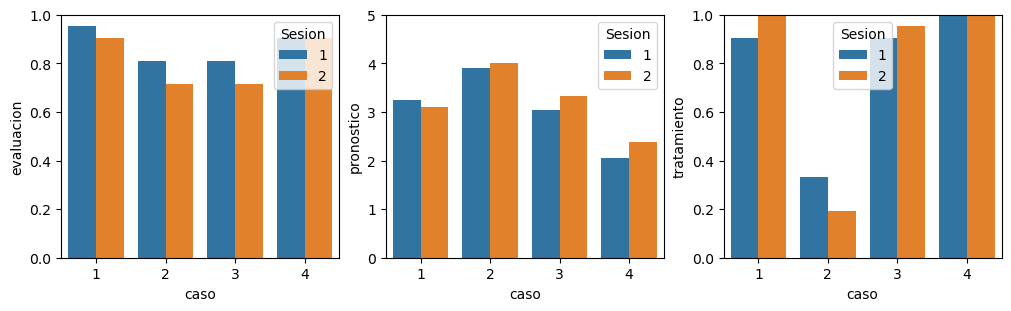

In [349]:
plt.figure(figsize=(10,3),layout='constrained')
plt.subplot(1,3,1)
sns.barplot(data = df_all,y='evaluacion', x='caso', hue='Sesion',errorbar=None)
# plt.ylim([0,1])
plt.subplot(1,3,2)

sns.barplot(data = df_all,y='pronostico', x='caso', hue='Sesion',errorbar=None)
plt.ylim([0,5])
plt.subplot(1,3,3)
df_all['tratamiento'] =  df_all['tme']>0
sns.barplot(data = df_all,y='tratamiento', x='caso', hue='Sesion',errorbar=None)
plt.ylim([0,1])

In [ ]:
1 Atrofia
2 Sin atrofia
3 Sin atrofia
4 Atrofia

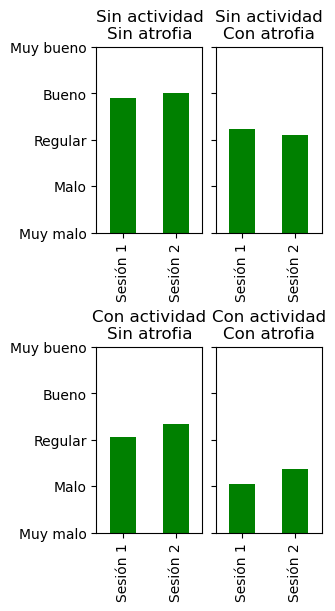

In [429]:
df_caso1 = pd.DataFrame({'0': [3.24, 3.10]},
                        index=['Sesión 1', 'Sesión 2'])
df_caso2 = pd.DataFrame({'0': [3.90,	4.00]},
                        index=['Sesión 1', 'Sesión 2'])
df_caso3 = pd.DataFrame({'0': [3.05,	3.33]},
                        index=['Sesión 1', 'Sesión 2'])
df_caso4 = pd.DataFrame({'0': [2.05,	2.38]},
                        index=['Sesión 1', 'Sesión 2'])
 
fig,axs=plt.subplots(2,2,layout='constrained',figsize=(3.2,6))
axs = np.ravel(axs)
# fig,axs=plt.subplots(1,4,layout='constrained',figsize=(8,3))
# axs = np.ravel(axs)
df_caso1.plot(ax=axs[1],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso2.plot(ax=axs[0],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso3.plot(ax=axs[2],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso4.plot(ax=axs[3],kind='bar', stacked=True,color=['green', 'yellow','red'])
axs[1].set_title('Sin actividad\nCon atrofia')
axs[0].set_title('Sin actividad\nSin atrofia')
axs[2].set_title('Con actividad\nSin atrofia')
axs[3].set_title('Con actividad\nCon atrofia')

handles, labels = axs[1].get_legend_handles_labels()
labels = ('No TME','TME 1','TME 2')
axs[1].legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1, 0.5))

axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()
axs[0].set_ylim((1,5))
axs[1].set_ylim((1,5))
axs[2].set_ylim((1,5))
axs[3].set_ylim((1,5))
axs[0].set_yticks(ticks=(1,2,3,4,5),labels=('Muy malo','Malo','Regular','Bueno','Muy bueno'))
axs[1].set_yticks(ticks=(1,2,3,4,5),labels=('','','','',''))
axs[2].set_yticks(ticks=(1,2,3,4,5),labels=('Muy malo','Malo','Regular','Bueno','Muy bueno'))
axs[3].set_yticks(ticks=(1,2,3,4,5),labels=('','','','',''))

plt.show()

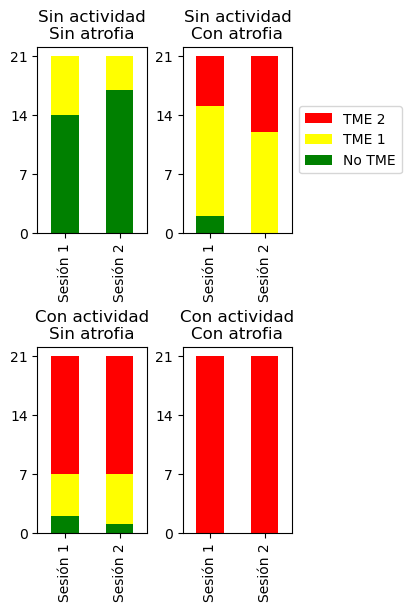

In [408]:
df_caso1 = pd.DataFrame({'0': [2, 0],
                         '1': [13, 12],
                         '2': [6, 9],},
                        index=['Sesión 1', 'Sesión 2'])
df_caso2 = pd.DataFrame({'0': [14, 17],
                         '1': [7, 4],
                         '2': [0, 0],},
                        index=['Sesión 1', 'Sesión 2'])
df_caso3 = pd.DataFrame({'0': [2, 1],
                         '1': [5, 6],
                         '2': [14, 14],},
                        index=['Sesión 1', 'Sesión 2'])
df_caso4 = pd.DataFrame({'0': [0, 0],
                         '1': [0, 0],
                         '2': [21, 21],},
                        index=['Sesión 1', 'Sesión 2'])
 
fig,axs=plt.subplots(2,2,layout='constrained',figsize=(4,6))
axs = np.ravel(axs)
# fig,axs=plt.subplots(1,4,layout='constrained',figsize=(8,3))
# axs = np.ravel(axs)
df_caso1.plot(ax=axs[1],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso2.plot(ax=axs[0],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso3.plot(ax=axs[2],kind='bar', stacked=True,color=['green', 'yellow','red'])
df_caso4.plot(ax=axs[3],kind='bar', stacked=True,color=['green', 'yellow','red'])
axs[1].set_title('Sin actividad\nCon atrofia')
axs[0].set_title('Sin actividad\nSin atrofia')
axs[2].set_title('Con actividad\nSin atrofia')
axs[3].set_title('Con actividad\nCon atrofia')

handles, labels = axs[1].get_legend_handles_labels()
labels = ('No TME','TME 1','TME 2')
axs[1].legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1, 0.5))

axs[0].get_legend().remove()
# axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()
axs[0].set_yticks(ticks=(0,7,14,21))
axs[1].set_yticks(ticks=(0,7,14,21))
axs[2].set_yticks(ticks=(0,7,14,21))
axs[3].set_yticks(ticks=(0,7,14,21))
plt.show()